In [1]:
import sys
import os
from dotenv import load_dotenv
load_dotenv()
sys.path.insert(0, os.getenv('SRC_PATH'))

import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3
from src.volsurface import GridInterpVolSurface, KernelVolSurface, VAEPWVolSurface
from src.utils.data_helper import clean_data, VolSurfPointwiseDataset

import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from src.train import Trainer

import json

DB_PATH = os.getenv('DB_PATH')
CSV_PATH = os.getenv('CSV_PATH')
conn = sqlite3.connect(DB_PATH)
cursor = conn.cursor()

pd.set_option('future.no_silent_downcasting', True)

from src.utils.logger import setup_logger
logger = setup_logger('train')

In [2]:
query = """
SELECT date, symbol, exdate, last_date, cp_flag, strike_price, best_bid, best_offer, volume, open_interest, impl_volatility, delta
FROM opprc
"""
dtype = {
    'symbol': 'string',
    'cp_flag': 'string',
    'strike_price': 'float64',
    'best_bid': 'float64',
    'best_offer': 'float64',
    'volume': 'int64',
    'open_interest': 'int64',
    'impl_volatility': 'float64',
    'delta': 'float64'
}
df_raw = pd.read_sql_query(query, conn, parse_dates=['date', 'exdate', 'last_date'])
df_raw = df_raw.replace('', np.nan) # sqlite returns empty strings for NULL values
df_raw = df_raw.astype(dtype)

df = clean_data(df_raw)

[2025-04-20 20:48:36] [INFO] src.utils.data_helper (50) : Bad data - Filtered 1110238 rows, Retained sample 76.67%
[2025-04-20 20:48:47] [INFO] src.utils.data_helper (63) : Consecutive trading stats completed
[2025-04-20 20:48:48] [INFO] src.utils.data_helper (86) : Consecutive trading - Filtered 2341950 rows, Retained sample 35.81%
[2025-04-20 20:48:48] [INFO] src.utils.data_helper (91) : Moneyness calculation completed


In [3]:
model_name = "vae_pw_improve_0"
train_model = False
load_model = True
save_model = False
data_dir = CSV_PATH + "/predicted_vol_surfaces.json"  # Path to the volatility surfaces dataset
batch_size = 32
epochs = 10

SRC_PATH = os.getenv('SRC_PATH')
os.chdir(SRC_PATH)
trainer = Trainer(model_name)
trainer.create_model()

[2025-04-20 20:48:48] [INFO] src.train (61) : Using device: mps


In [4]:
maturity_grid = np.array([1, 7, 30, 60, 90, 180, 360, 720])
delta_grid = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

with open(data_dir, "r") as f:
    data = json.load(f)

mapping_ids = {dt: i for i, dt in enumerate(sorted(map(lambda x: x[:10], data.keys())))}

df['mapping_ids'] = df['date'].dt.strftime('%Y-%m-%d').map(mapping_ids)

vol_surfaces = []
for key in sorted(data.keys()):
    surface = torch.tensor(data[key], dtype=torch.float32)
    vol_surfaces.append(surface.flatten())  # Flatten 2D to 1D

data_tensor = torch.stack(vol_surfaces)
pw_grid_data = torch.tensor(df[['moneyness', 'ttm']].values, dtype=torch.float32)
# !only for test run
# pw_grid_data[:, 0] = pw_grid_data[:, 0] / 365.0
pw_vol_data = torch.tensor(df['impl_volatility'].values, dtype=torch.float32)
mapping_ids = torch.tensor(df['mapping_ids'].values).long()

assert data_tensor.shape[0] == max(mapping_ids) + 1

dataset = VolSurfPointwiseDataset(pw_grid_data, pw_vol_data, data_tensor, mapping_ids)
train_loader = DataLoader(
    dataset, 
    batch_size=trainer.batch_size,
    shuffle=True
)

In [5]:
trainer.load_model( f"params/{trainer.model_name}.pth")

[2025-04-20 20:48:51] [INFO] src.train (137) : Model loaded from params/vae_pw_improve_0.pth


In [6]:

# latent_representations = trainer.model.encoder(data_tensor.to(trainer.device))


In [9]:
trainer.model.eval()
data_tensor = data_tensor.to(trainer.device)
encoder_outputs_mean = []
encoder_outputs_logvar = []
with torch.no_grad(): 
    for input_data in data_tensor:
        encoder_output = trainer.model.encoder(input_data.unsqueeze(0))
        encoder_outputs_mean.append(encoder_output[0])
        encoder_outputs_logvar.append(encoder_output[1])
encoder_outputs_mean = torch.cat(encoder_outputs_mean, dim=0)
encoder_outputs_logvar = torch.cat(encoder_outputs_logvar, dim=0)

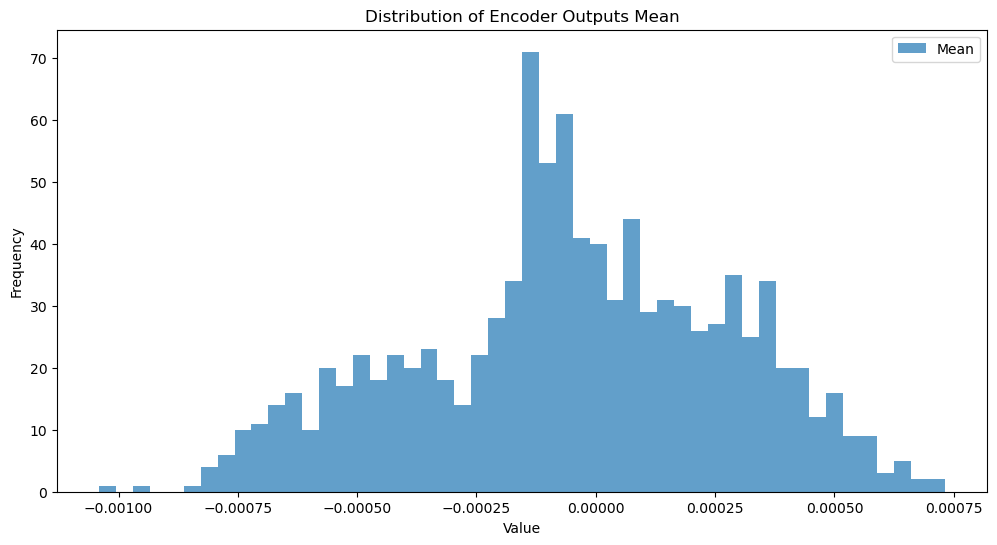

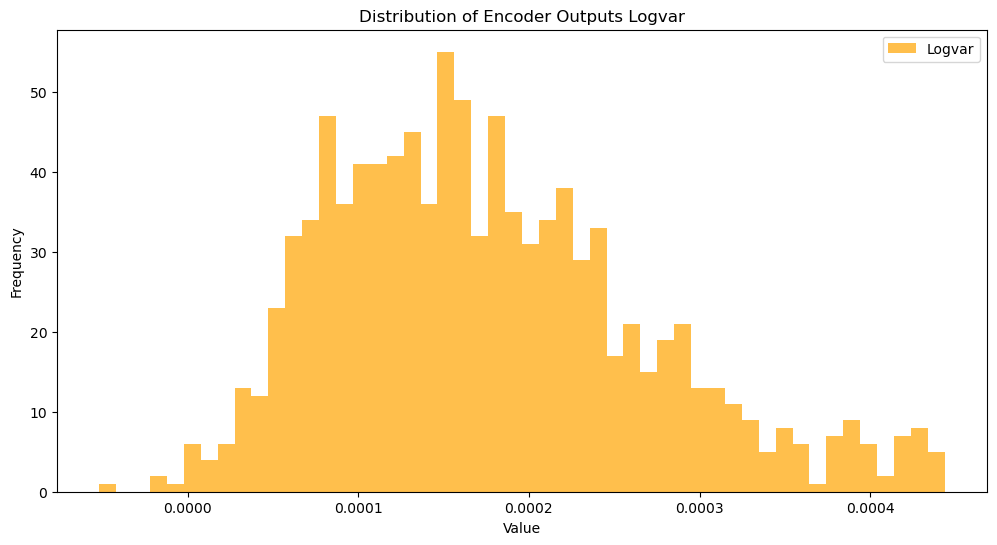

In [10]:
import matplotlib.pyplot as plt

# Plot the distribution of mean
plt.figure(figsize=(12, 6))
plt.hist(encoder_outputs_mean.cpu().numpy().flatten(), bins=50, alpha=0.7, label='Mean')
plt.title('Distribution of Encoder Outputs Mean')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Plot the distribution of logvar
plt.figure(figsize=(12, 6))
plt.hist(encoder_outputs_logvar.cpu().numpy().flatten(), bins=50, alpha=0.7, label='Logvar', color='orange')
plt.title('Distribution of Encoder Outputs Logvar')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

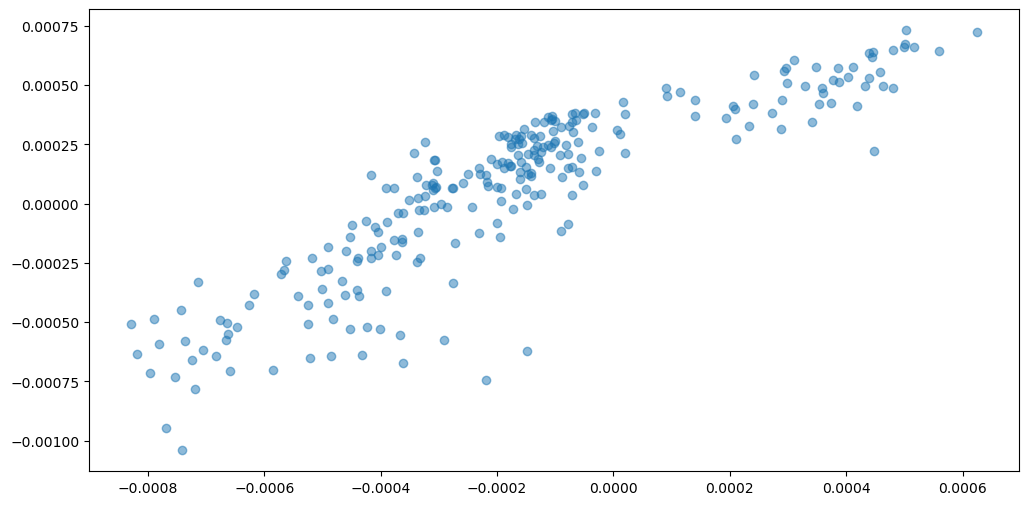

In [13]:
encoder_outputs_mean_ = encoder_outputs_mean.cpu().numpy()
# compute variance for encoder outputs mean
encoder_outputs_mean_var = np.var(encoder_outputs_mean_, axis=0)
# get the indices of the largest 2 var
indices = np.argsort(encoder_outputs_mean_var)[-2:]
encoder_outputs_mean_ = encoder_outputs_mean_[:, indices]
# plot
plt.figure(figsize=(12, 6))
plt.scatter(encoder_outputs_mean_[:, 0], encoder_outputs_mean_[:, 1], alpha=0.5)